In [1]:
import json
import csv

import numpy as np
import pandas as pd

import seaborn as sns
print(sns.__version__)

from utils import *
%load_ext autoreload
%autoreload 2

%matplotlib inline

0.7.1


## Converting tweet json to csv

In [302]:
tweets_path = 'data/tweets/tweets.hiking.working.sleptwell/hiking_working_slept.well_tweets_2017.11.03.02.30.json'
with open(tweets_path, mode='r') as f:
    data_json = f.readlines()

data_python = []

for tweet in data_json:
    data_python.append(json.loads(tweet))

csv_out = open('tweets_out_ASCII.csv', mode='w') #opens csv file
writer = csv.writer(csv_out) #create the csv writer object
 
fields = ['created_at', 'text', 'screen_name', 
#          'followers', 'friends', 'rt', 'fav', 
          'hashtags',
          'placename', 'city','province', 'country', 'latitude', 'longitude'] #field names
writer.writerow(fields) #writes field


for line in data_python:
 
    #writes a row and gets the fields from the json object
    #screen_name and followers/friends are found on the second level hence two get methods
    writer.writerow([line.get('created_at'),
                     line.get('text').encode('unicode_escape'), #unicode escape to fix emoji issue
                     line.get('user').get('screen_name'),
    #                 line.get('user').get('followers_count'),
    #                 line.get('user').get('friends_count'),
    #                 line.get('retweet_count'),
    #                 line.get('favorite_count'),
                     ','.join([i['text'] for i in line.get('entities').get('hashtags')]), 
                     line.get('place').get('full_name'),
                     line.get('place').get('name'),                     
                     line.get('place').get('full_name').split(', ')[-1],
                     line.get('place').get('country'),
                     line.get('geo').get('coordinates')[0] if line.get('geo') else '',
                     line.get('geo').get('coordinates')[1] if line.get('geo') else ''])

csv_out.close()

In [303]:
tweets_df = pd.read_csv('./tweets_out_ASCII.csv')
tweets_df.head()

,created_at,text,screen_name,hashtags,placename,city,province,country,latitude,longitude
0,Mon Oct 30 04:36:02 +0000 2017,b'#swimdog #waterdog #dog #dogs #olddog #olddo...,sslaxfan,"swimdog,waterdog,dog,dogs,olddog,olddogs,dogsw...","Georgian Bay, Ontario",Georgian Bay,Ontario,Canada,44.8990,-79.7580
1,Mon Oct 30 22:45:45 +0000 2017,"b""Late night working at #hamont #cityhall. Que...",annlamanes,"hamont,cityhall,devilsnight","Hamilton, Ontario",Hamilton,Ontario,Canada,43.2553,-79.8731
2,Mon Oct 30 08:33:50 +0000 2017,"b""Here\\u2019s a song for you\\u2026 My Time b...",twizmwhytepiece,NaN,"Brampton, Ontario",Brampton,Ontario,Canada,NaN,NaN
3,Mon Oct 30 08:36:01 +0000 2017,"b""When you're working night shift n miss #Worl...",JonnyHGolf,WorldSeries2017,"Edmonton, Alberta",Edmonton,Alberta,Canada,NaN,NaN
4,Mon Oct 30 07:43:26 +0000 2017,b'@Raurrrrr I\\u2019m still working out the or...,Featherweight_,NaN,"Bradford West Gwillimbury, Ontario",Bradford West Gwillimbury,Ontario,Canada,NaN,NaN


## Computing geolocations of division names

In [142]:
cities = pd.read_csv('./Canadian territory Ids.csv')
cities.head()

,province_id,province_name,division_id,division_name
0,46,Manitoba,4609,Division No. 9
1,59,British Columbia / Colombie-Britannique,5901,East Kootenay
2,59,British Columbia / Colombie-Britannique,5933,Thompson-Nicola
3,48,Alberta,4816,Division No. 16
4,59,British Columbia / Colombie-Britannique,5919,Cowichan Valley


In [106]:
manitoba_regions = {
    1: 'Eastern Manitoba',
    2: 'Steinbach',
    3: 'Pembina Valley',
    4: 'Pilot Mound',
    5: 'South West Westman',
    6: 'Virden',
    7: 'Brandon',
    8: 'Central Manitoba',
    9: 'Portage la Prairie',
    10: 'Whitehorse Plains',
    11: 'Winnipeg',
    12: 'Beausejour',
    13: 'Selkirk Area',
    14: 'Interlake',
    15: 'Western Manitoba Westman',
    16: 'Roblin',
    17: 'Dauphin',
    18: 'Interlake',
    19: 'North East Northern Region',
    20: 'Swan River',
    21: 'Flin Flon',
    22: 'Thompson',
    23: 'Churchill'
}

In [138]:
from geopy.geocoders import Nominatim
geocoder=  Nominatim()
latitude = []
longitude = []
for i in range(len(cities)):
    query = ', '.join([cities.loc[i].division_name, cities.loc[i].province_name])
    geolocation = geocoder.geocode(query)
    if cities.loc[i].province_name == 'Manitoba':
        division_number = int(cities.loc[i].division_name.split(', ')[0].split('. ')[-1])
        query = ', '.join([manitoba_regions[division_number], cities.loc[i].province_name])
        geolocation = geocoder.geocode(query)
    if not geolocation:      
        print("Couldn't find", query)
        latitude.append('')
        longitude.append('')
    else:
        print(i, query, geolocation.latitude, geolocation.longitude)
        latitude.append(geolocation.latitude)
        longitude.append(geolocation.longitude)
        #lat_long.append((geolocation.latitude, geolocation.longitude))
        
cities['latitude'] = pd.Series(latitude)
cities['longitude'] = pd.Series(longitude)
cities.to_csv('canadian_territories.csv')        

0 Portage la Prairie, Manitoba 49.972422 -98.289185
Couldn't find East Kootenay, British Columbia / Colombie-Britannique
2 Thompson-Nicola, British Columbia / Colombie-Britannique 50.2598803 -121.4070114
3 Division No. 16, Alberta 52.1476514 -106.6680964
4 Cowichan Valley, British Columbia / Colombie-Britannique 48.81174475 -123.803624662522
5 Flin Flon, Manitoba 54.77440345 -101.882480716359
6 Central Manitoba, Manitoba 50.9959116 -98.7987473049144
7 Division No. 11, Alberta 52.1476514 -106.6680964
8 Division No.  2, Alberta 50.9227196 -102.791443
9 Bulkley-Nechako, British Columbia / Colombie-Britannique 54.4921242 -125.809230711388
10 Division No. 14, Saskatchewan 53.1869562 -105.7210493
11 Pilot Mound, Manitoba 49.2248362 -98.9121735
12 Cariboo, British Columbia / Colombie-Britannique 49.2477785 -122.8897737
13 Division No.  1, Alberta 52.1531542 -106.6680651
14 Winnipeg, Manitoba 49.884017 -97.168579
15 Sunshine Coast, British Columbia / Colombie-Britannique 49.6212539 -124.026415

In [311]:
cities.to_csv('canadian_territories.csv', index=False)

In [312]:
mapcities_df = pd.read_csv('canadian_territories.csv')
mapcities_df.head()

,province_id,province_name,division_id,division_name,latitude,longitude
0,46,Manitoba,4609,Division No. 9,49.972422,-98.289185
1,59,British Columbia / Colombie-Britannique,5901,East Kootenay,NaN,NaN
2,59,British Columbia / Colombie-Britannique,5933,Thompson-Nicola,50.259880,-121.407011
3,48,Alberta,4816,Division No. 16,52.147651,-106.668096
4,59,British Columbia / Colombie-Britannique,5919,Cowichan Valley,48.811745,-123.803625


## Preprocessing tweets

In [293]:
sedentary_pattern = r'working|work|watch|chill|games'
sleeping_pattern = r'sleep'
physical_activity = r'run|hiking|hike'

def count_topic(x, regex):
    hashtags = sum(x['hashtags'].str.contains(regex) == True)
    text = sum(x['text'].str.contains(regex) == True)
    return hashtags + text

def filter_tweets(x):
    return pd.Series(dict(num_tweets = x['text'].count(),
                          physical_activity = count_topic(x, physical_activity),
                          sedentary_behavior = count_topic(x, sedentary_pattern),
                          sleeping = count_topic(x, sleeping_pattern),
                          latitude = x['latitude'].mean(),
                          longitude = x['longitude'].mean()))

In [473]:
tweets_df = pd.read_csv('./tweets_out_ASCII.csv')
regions_df = tweets_df.groupby('placename').apply(filter_tweets)
regions_df.head()

,latitude,longitude,num_tweets,physical_activity,sedentary_behavior,sleeping
placename,,,,,,
"Abbotsford, British Columbia",NaN,NaN,1.0,0.0,1.0,0.0
Alderlea,NaN,NaN,1.0,0.0,1.0,0.0
"Banff, Alberta",51.1667,-115.567,1.0,2.0,0.0,0.0
"Barrie, Ontario",NaN,NaN,3.0,0.0,3.0,0.0
"Belleville, Ontario",NaN,NaN,1.0,0.0,1.0,0.0


## Find geolocation for tweet regions

In [384]:
for region in regions_df.index.tolist():
    geolocation = geocoder.geocode(region, timeout=10)
    if geolocation:
        latitude = geolocation[-1][0]
        longitude = geolocation[-1][1]
        if pd.isnull(regions_df.loc[region].latitude):
            regions_df.loc[region].latitude = latitude
            regions_df.loc[region].longitude = longitude
            print(geolocation, '(%.4f, %.4f)' % (latitude, longitude))
    else:
        print("Couldn't locate", region)

Couldn't locate Hilton Toronto/Markham Suites Conference Centre & Spa
Couldn't locate Improvement District No.  9 Banff, Alberta
Couldn't locate Kings, Subd. B, Nova Scotia
Kingston, Ontario, Canada (44.2307, -76.4813)
Kitchener, Regional Municipality of Waterloo, Ontario, Canada (43.4532, -80.4944)
Couldn't locate Last Best Brewing And Distilling
Couldn't locate Lesser Slave River No.124, Alberta
Markham, York Region, Ontario, Canada (43.8543, -79.3268)
Medicine Hat, City of Medicine Hat, Alberta, Canada (50.0430, -110.6790)
Milton, Halton Region, Ontario, Canada (43.5137, -79.8828)
Mississauga, Algoma District, Ontario, Canada (46.1939, -83.0110)
Montréal, Montréal (06), Québec, Canada (45.4972, -73.6104)
Mount Pearl, Newfoundland and Labrador, Canada (47.5185, -52.8061)
New Tecumseth, Simcoe, Ontario, Canada (44.0819, -79.7744)
New Westminster, Metro Vancouver, British Columbia, Canada (49.2057, -122.9109)
Newmarket, York Region, Ontario, Canada (44.0563, -79.4617)
Niagara Falls, Re

In [468]:
from geopy.distance import vincenty

def find_closest_city(lat, long):
    distances = mapcities_df.dropna().apply(
        lambda row: vincenty((lat, long), (row.latitude, row.longitude)).km, axis=1)
    return distances.idxmin()
    closest = mapcities_df.loc[distances.idxmin()]
    return closest

mapcities_df['num_tweets'] = 0
mapcities_df['physical_activity'] = 0
mapcities_df['sedentary_behavior'] = 0
mapcities_df['sleeping'] = 0

for idx in range(len(regions_df)):
    idx_name = regions_df.index[idx]
    lat, long = regions_df.loc[idx_name, ['latitude', 'longitude']]
    if not pd.isnull(lat) and not pd.isnull(long):
        #print(idx_name)
        closest_idx = find_closest_city(lat, long)
        mapcities_df.loc[closest_idx, 
                         ['num_tweets', 'physical_activity', 
                          'sedentary_behavior', 'sleeping']] += regions_df.loc[idx_name, 
                         ['num_tweets', 'physical_activity', 
                          'sedentary_behavior', 'sleeping']]

In [476]:
mapcities_df.head()

,province_id,province_name,division_id,division_name,latitude,longitude,num_tweets,physical_activity,sedentary_behavior,sleeping
0,46,Manitoba,4609,Division No. 9,49.972422,-98.289185,0.0,0.0,0.0,0.0
1,59,British Columbia / Colombie-Britannique,5901,East Kootenay,NaN,NaN,0.0,0.0,0.0,0.0
2,59,British Columbia / Colombie-Britannique,5933,Thompson-Nicola,50.259880,-121.407011,1.0,1.0,0.0,0.0
3,48,Alberta,4816,Division No. 16,52.147651,-106.668096,0.0,0.0,0.0,0.0
4,59,British Columbia / Colombie-Britannique,5919,Cowichan Valley,48.811745,-123.803625,1.0,2.0,0.0,0.0


In [471]:
mapcities_df.num_tweets.sum()

224.0

num_tweets            228
physical_activity      30
sedentary_behavior    218
sleeping                1
dtype: int64


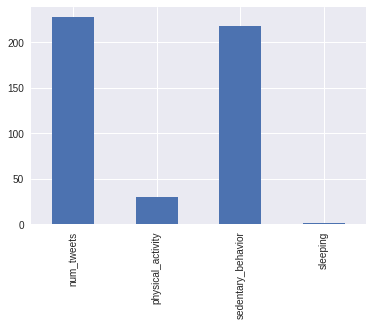

In [283]:
print(regions_df.sum())
regions_df.sum().plot(kind='bar')

In [477]:
mapcities_df.to_csv('map_output.csv', index=False)

In [502]:
from utils import *
import glob
from tqdm import tqdm

tweet_folder = '/media/storage/RawTweets/'

fnames = glob.glob(tweet_folder + '*.json')

data_json = []
for tweets_path in tqdm(fnames):
    with open(tweets_path, mode='r') as f:
        data_json += f.readlines()

data_python = []

for tweet in data_json:
    data_python.append(json.loads(tweet))

csv_out = open('tweets_out_BIG.csv', mode='w') #opens csv file
writer = csv.writer(csv_out) #create the csv writer object
 
fields = ['created_at', 'text', 'screen_name', 
          'hashtags',
          'placename', 'city','province', 'country', 'latitude', 'longitude'] 
writer.writerow(fields)

missing_places = 0
for line in tqdm(data_python):
    if line.get('place'):
        writer.writerow([line.get('created_at'),
                     line.get('text').encode('unicode_escape'), #unicode escape to fix emoji issue
                     line.get('user').get('screen_name'),
                     ','.join([i['text'] for i in line.get('entities').get('hashtags')]), 
                     line.get('place').get('full_name'),
                     line.get('place').get('name'),                     
                     line.get('place').get('full_name').split(', ')[-1],
                     line.get('place').get('country'),
                     line.get('geo').get('coordinates')[0] if line.get('geo') else '',
                     line.get('geo').get('coordinates')[1] if line.get('geo') else ''])
    else:
        missing_places += 1

csv_out.close()

100%|██████████| 840389/840389 [00:10<00:00, 78943.22it/s]


In [2]:
from utils import *

tweet_folder = '/media/storage/RawTweets/'
outpath = 'tweets_out_BIG.csv'

tweet_folder_json_to_csv(tweet_folder, outpath)

100%|██████████| 840389/840389 [00:09<00:00, 84829.99it/s]


In [19]:
tweets_df = pd.read_csv('./tweets_out_BIG.csv')
regions_df = tweets_df.groupby('placename').apply(filter_tweets)
regions_df.head()

,latitude,longitude,num_tweets,physical_activity,sedentary_behavior,sleeping
placename,,,,,,
#FNLROM at Royal Ontario Museum,NaN,NaN,1.0,0.0,0.0,0.0
#Sadness,NaN,NaN,1.0,0.0,0.0,1.0
10 Dundas East,NaN,NaN,1.0,0.0,0.0,0.0
100 Bay Street South,NaN,NaN,1.0,0.0,0.0,0.0
101 WRIF,NaN,NaN,1.0,0.0,0.0,0.0


In [47]:
print (sum(tweets_df.country == "United States"))
print (sum(tweets_df.country == "United States") / len(tweets_df))

614939
0.73203015073


In [32]:
sedentary_pattern = r'working|work|watch|chill|games'
sleeping_pattern = r'sleep|slept'
physical_activity = r'run|hiking|hike'

toronto_tweets = tweets_df.loc[tweets_df.city == "Toronto"]

sedentary = toronto_tweets.text.str.contains(sedentary_pattern)
sleeping = toronto_tweets.text.str.contains(sleeping_pattern)
physical = toronto_tweets.text.str.contains(physical_activity)

cond = sedentary | sleeping | physical

In [44]:
toronto_tweets.ix[cond == False].text.to_csv('bad_tweets.csv', index=False)

In [22]:
regions_df.sort_values('num_tweets', ascending=False)

,latitude,longitude,num_tweets,physical_activity,sedentary_behavior,sleeping
placename,,,,,,
"Toronto, Ontario",43.686312,-79.382941,45583.0,353.0,1734.0,211.0
"Pennsylvania, USA",40.371374,-76.727072,37688.0,388.0,1645.0,201.0
"Ohio, USA",40.419260,-82.578780,31298.0,292.0,1143.0,302.0
"New York, USA",42.468399,-75.322483,28089.0,270.0,1154.0,149.0
"Boston, MA",42.351898,-71.067884,23821.0,210.0,1238.0,101.0
"Indiana, USA",39.807075,-86.314244,17753.0,199.0,803.0,136.0
"Michigan, USA",43.462316,-84.710956,14368.0,169.0,648.0,125.0
"Detroit, MI",42.353659,-83.076858,13512.0,101.0,552.0,121.0
"Montréal, Québec",45.507899,-73.584168,11794.0,81.0,430.0,37.0


In [58]:
sum(regions_df.latitude.isnull())

6688

In [65]:
import geocoder

for idx, placename in enumerate(regions_df.index.tolist()):
    if pd.isnull(regions_df.loc[placename].latitude):
        g = geocoder.google(placename)
        if g:
            latitude = g.latlng[0]
            longitude = g.latlng[1]
            regions_df.loc[placename].latitude = latitude        
            regions_df.loc[placename].longitude = longitude
        else:
            print('Couldnt find %s' % placename)

Couldnt find 999 BOB FM / 1031 Virgin Radio / TSN Radio 1290
Couldnt find A1-A Conference Room: TJX
Couldnt find Acapulco Mexican Grill
Couldnt find Akers Hall
Couldnt find Akwesasne (Part) 59, Ontario
Couldnt find Albany Public Library - Howe Branch
Couldnt find Alumni Memorial Pool
Couldnt find Anonymous Private Investigaion
Couldnt find ArcelorMittal Dofasco
Couldnt find Arret 200\300 montée Robert
Couldnt find Art Wright Stadium
Couldnt find BU Metcalf Center For Science & Engineering Physics Department
Couldnt find Baber Room
Couldnt find Bank Street Wine & Spirits
Couldnt find Beinecke Rare Book and Manuscript Library
Couldnt find Ben & Jerry's
Couldnt find Ben Light Gymnasium
Couldnt find Benton Heights, MI
Couldnt find Benton, IN
Couldnt find Bertram Field
Couldnt find Bethlehem Lutheran Church
Couldnt find Beveridge Arts Centre
Couldnt find Big Al's Body Shop
Couldnt find Bikini Bottom
Couldnt find Billington Heights, NY
Couldnt find Biomat USA Plasma Center
Couldnt find Black

KeyboardInterrupt: 

In [49]:
tweets_df.loc[tweets_df.placename == 'Fort Erie Native Friendship Centre']

,created_at,text,screen_name,hashtags,placename,city,province,country,latitude,longitude
367354,Mon Oct 30 22:32:04 +0000 2017,b'Wonderful skills development workshop for @G...,mrtmarr,"CourageToSoar,ExperientalEd",Fort Erie Native Friendship Centre,Fort Erie Native Friendship Centre,Fort Erie Native Friendship Centre,Canada,NaN,NaN
